In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from astropy import constants
import matplotlib.patches as patches
from scipy.special import gamma
from scipy.interpolate import interp1d

figparams = {
       'text.latex.preamble': [r'\usepackage{amsmath}'],
       'text.usetex':True,
       'axes.labelsize':20.,
       'xtick.labelsize':18,
       'ytick.labelsize':18,
       'font.family':'DejaVu Sans',
       'legend.fontsize':12,
       'axes.titlesize' : 20}
plt.rcParams.update(figparams)

In [ ]:
pi = np.pi
sin = np.sin
cos = np.cos
sqrt=np.sqrt
c = constants.c
H0 = (70*u.km).to(1*u.m)/u.s/u.Mpc
G = 6.67e-11*u.m**3/u.kg/u.s**2
Gc3 = G/c**3

def logMBH(sig_): return 8.32+5.64*np.log10(sig_/200)
def logMbulge(logmbh_): return (logmbh_-8.46)/1.05+11
def fISCO(logM_):
    fmax_pf = (c**3/(6**1.5*pi*G)).to(u.kg/u.s)
    Mc = (10**logM_*u.Msun).to(1*u.kg)
    return fmax_pf/Mc*2**.3
folder = '/Users/WangYijun/Dropbox/Apps/Overleaf/estoiles_paper_2/'

## Fig 1: hc(f) sensitivity

In [ ]:
## PTA
fmin_PTA = (1/(12.5*u.yr)).to(1*u.Hz)
fmax_PTA = (17/u.yr).to(1*u.Hz)
f_PTA = np.linspace(fmin_PTA,fmax_PTA,100).to(1/u.s)  
dt = (1/fmax_PTA).to(1*u.s)
sig = (250*u.ns).to(1*u.s)
hc_PTA = np.sqrt(24*np.pi**2*dt)*sig*f_PTA**1.5
## LISA
fmin_LISA = 1e-5*u.Hz
fmax_LISA = 1e-2*u.Hz
L = (2.5*u.Gm).to(1*u.m)
fs = 19.09*u.mHz
f = np.linspace(fmin_LISA,fmax_LISA,100).to(1*u.mHz)
f_LISA = f.to(1*u.Hz)
P_oms = (1.5e-11*u.m)**2*(1+(2*u.mHz/f)**4)/u.Hz
P_acc = (3e-15*u.m/u.s**2)**2*(1+(.4*u.mHz/f)**2)*(1+(f/(8*u.mHz))**4)/u.Hz
Sn = 10/(3*L**2)*(P_oms+4*P_acc/(2*np.pi*f)**4)*(1+.6*(f/fs)**2)
hc_LISA = np.sqrt(Sn*f_LISA)

In [ ]:
# Roman and Gaia, src agnostic
datals = [[1e8,(1.1*u.mas).to(1*u.rad),(6*72*u.d).to(1*u.s).value,(15*u.min).to(1*u.s).value],
          [1e9,(.7*u.mas).to(1*u.rad),(5*u.yr).to(1*u.s).value,(5/70*u.yr).to(1*u.s).value]]
Nf = 100
freqref = (1/u.yr).to(1/u.s).value
smbhlim = []
hc_src_ag = []

for data in datals:
    Ns,sig_ss,Tobs,dtobs = data
    fmax = 1/dtobs
    fmin = 1/Tobs
    logfs = np.linspace(np.log(fmin),np.log(fmax),Nf)
    dlogf = np.diff(logfs)[0]
    freq = np.exp(logfs)
    hc = np.sqrt(2*freq/Tobs/Ns)*sig_ss*dtobs

    hcinj = (freq/freqref)**(-2/3)
    A2 = 1/(dlogf*np.sum(((hcinj/hc)**2)))
    smbhlim.append(np.sqrt(A2).value)

    alpha_arr = np.linspace(-5,5,200)
    hcarr = np.empty([len(alpha_arr),len(freq)])
    for i,alpha in enumerate(alpha_arr):
        hcinj = (freq/freqref)**alpha
        A2 = 1/(dlogf*np.sum(((hcinj/hc)**2)))
        hcarr[i] = np.sqrt(A2)*hcinj
    hc_src_ag.append([freq,np.amax(hcarr,axis=0)])

In [63]:
print("SMBHB amp: \nRoman", smbhlim[0],"\nGaia", smbhlim[1],'\n')
Acp = 2.8e-15
snr = Acp/np.array(smbhlim)
print('SNR:')
print("Roman, full signal: ",snr[0],"\nRoman, ms signal: ",snr[0]/100,"\nGaia, full signal: ",snr[1],'\n')

occfrac = (np.array(smbhlim)/(2.8e-15))**2*1.5
print('number density upper limit (null detection)'+'\nRoman, full signal:',snr[0],
      "\nRoman, ms signal: ",snr[0]/100,"\nGaia, full signal: ",snr[1])

SMBHB amp: 
Roman 2.3360342924999927e-17 
Gaia 1.104910000115867e-15 

SNR:
Roman, full signal:  119.86125413439362 
Roman, ms signal:  1.1986125413439361 
Gaia, full signal:  2.5341430521095627 

number density upper limit (null detection)
Roman, full signal: 119.86125413439362 
Roman, ms signal:  1.1986125413439361 
Gaia, full signal:  2.5341430521095627


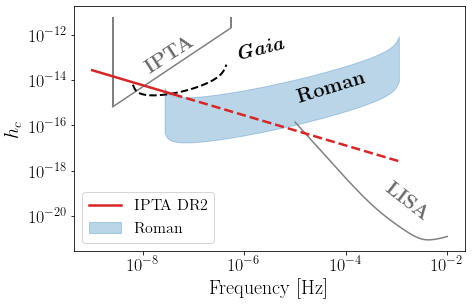

In [65]:
fig,ax = plt.subplots(figsize=(7.,4.5))

ax.loglog(f_LISA,hc_LISA,color='gray')
ax.text(5e-4,6e-21,r'\bf LISA',fontsize=20,color='dimgrey',rotation=-38)
ax.loglog(f_PTA,hc_PTA,color='gray')
ax.text(1e-8,2e-14,r'\bf IPTA',color='dimgrey',fontsize=20,rotation=33)
ymin,ymax = ax.get_ylim()
ax.vlines(f_PTA[0].value,hc_PTA[0].value,ymax,linewidth=2,color='gray')
ax.vlines(f_PTA[-1].value,hc_PTA[-1].value,ymax,linewidth=2,color='gray')

ax.text(1e-5,1e-15,r'\bf Roman',color='k',fontsize=20,rotation=17)
r,g,b = np.array([31,119,180])/255
ax.fill_between(hc_src_ag[0][0],hc_src_ag[0][1],100*hc_src_ag[0][1],label='Roman',
                color=(r,g,b),alpha=0.3)
ax.loglog(hc_src_ag[1][0],hc_src_ag[1][1],color='k',linestyle='dashed',linewidth=2)
ax.text(7e-7,9e-14,r'\bf{\textit{Gaia}}',color='k',fontsize=20,rotation=14)

## IPTA DR2
fmin,fmax = 1e-9,4e-8
Acp = 2.8e-15
fnanograv = np.array([fmin,fmax])
r,g,b = np.array([214,39,40])/255
ax.plot(fnanograv,Acp*(fnanograv/freqref)**(-2/3),color=(r,g,b),linewidth=2.5,label='IPTA DR2')
fmin,fmax = fmax,max(hc_src_ag[0][0])
fnanograv = np.array([fmin,fmax])
ax.plot(fnanograv,Acp*(fnanograv/freqref)**(-2/3),color=(r,g,b),linestyle='dashed',linewidth=2.5)
ax.legend(loc='lower left',fontsize=16)
ax.set_xlabel('Frequency [Hz]',fontsize=20)
ax.set_ylabel(r'$h_c$',fontsize=20)
plt.savefig(folder+'hc_sens.pdf',rasterized=True,dpi=450,bbox_inches='tight')

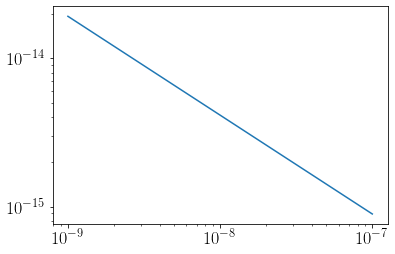

In [14]:
fmin,fmax = 1e-9,1e-7
Acp = 1.92e-15
fnanograv = np.array([fmin,fmax])
plt.loglog(fnanograv,Acp*(fnanograv/fyr)**(-2/3))

In [ ]:
(1*u.uas).to(1*u.rad)
(1.58e-5/4.2465*u.rad).to(1*u.arcsec)

## Fig 2: angular power spectrum

In [33]:
lval2 = np.arange(2,2000)
Nl2 = np.array([(x+2)*(x+1)*x*(x-1)/2 for x in lval2])
prefac = 8*pi/Nl2/(lval2*(lval2+1))
ClEB = prefac*np.sqrt(2)
dCl = np.sqrt(2/(2*lval2+1))

In [36]:
Acp = 2.8e-15
for idet in range(2):
    Ns,sig_ss,Tobs,dtobs,cl,lb = datals[idet]
    fmin,fmax = hc_src_ag[idet][0][0],hc_src_ag[idet][0][-1]
    print(fmin,fmax)
    int_hc2 = Acp**2/(fyr)**(-4/3)*3/4*(fmax**(-4/3)-fmin**(-4/3))
    delCnEB = (2*pi*sig_ss**2/Ns/(Tobs/dtobs)).value*dCl
    print(np.sqrt(sum(abs(ClEB*int_hc2/delCnEB))))

2.6791838134430743e-08 0.0011111111111111113
0.3931517552992078
6.33761756280579e-09 4.4363322939640535e-07
0.20948689340311755


In [10]:
snr = np.empty_like(dCl)
for i,ell in enumerate(lval2):
    theta = pi/ell
    frac = theta**2/(4*pi)
    binw = int(pi/theta)
    coeff = np.sqrt(frac)
    dsnr = (ClEB/(dCl/coeff))**2
    snr[i] = np.sqrt(np.sum(dsnr[i:]))
snr = snr[:998]

lval = np.arange(2,1000)
Nl2 = np.array([(x+2)*(x+1)*x*(x-1)/2 for x in lval])
prefac = 8*pi/Nl2/(lval*(lval+1))
ClEB = prefac*np.sqrt(2)
dCl = np.sqrt(2/(2*lval+1))
value = ClEB/dCl

def forward(xval_):
    return -np.interp(-xval_,-value,-snr)
def inverse(xval_):
    return -np.interp(-xval_,-snr,-value)

In [ ]:
tvls = np.array([40,10,2])
colors = ['gold','sandybrown','indianred']

fig,ax = plt.subplots(figsize=(6,4))
ax.loglog(lval,value,color='k')
lsample = np.empty_like(tvls)

for i,tv in enumerate(tvls):
    theta = (tv*u.deg).to(1*u.rad).value
    frac = theta**2/(4*pi)
    binw = int(pi/theta)
    Nbins = max(1,min(np.floor(max(lval)/binw).astype(int),len(lval)))
    ind_q = (np.arange(Nbins)*binw+int(binw/2)).astype(int)  # center of each bin
    lq = lval[ind_q]
    lsample[i] = binw+2
    meanCl = np.array([np.mean(ClEB[i*binw:(i+1)*binw]) for i in range(Nbins)])
    meandCl = np.array([np.mean(dCl[i*binw:(i+1)*binw]) for i in range(Nbins)])
    ax.bar(lq[1:],meanCl[1:]/meandCl[1:],log=True,width =binw,facecolor=colors[i],edgecolor='black',alpha=0.95,
           label=str(tv)+' deg')
    
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_\ell/(\delta C_\ell\sqrt{f_{\rm sky}})$')
ax.legend(loc='lower left',mode='expand',bbox_to_anchor=(0,1.0,1,0.2),ncol=3
          ,fontsize=15)
ax2 = ax.secondary_yaxis('right',functions=(forward,inverse))
ax2.set_ticks(1/(10**np.arange(14,1,-1)[::3]))
ax2.set_ylabel('SNR')
# ymin,_ = ax.get_ylim()
# for i,ell in enumerate(lsample):
#     ax.vlines(ell,ymin,value[ell-2])
#     ax.hlines(value[ell-2],ell,1000)
# plt.savefig(folder+'Cell.pdf',rasterized=True,dpi=450,bbox_inches='tight')

In [2]:
def Sfun(zl,sigma_v):
    h=0.70;
    phis=8e-3*h**3
    sigma_s=161
    alpha=2.32
    beta=2.67
    fp_arr = np.array([[-1.753749,0.204934,-0.057387],[-1.793255,-0.337430,-0.023378],[0.443074,1.219927,-0.280891],
                      [2.022011,-0.044166,0.007290]])

    func = phis*((sigma_v/sigma_s)**alpha)*np.exp(-(sigma_v/sigma_s)**beta)*beta/gamma(alpha/beta)*1/sigma_v
    eps = 0.01
    z_arr = np.array([1,0,0])
    logA,alp,b,g = np.sum(fp_arr*z_arr,axis=1)
    sig_t = np.array([sigma_v+eps,sigma_v-eps])/10**g
    N = 10.**logA*sig_t**(alp+b*np.log10(sig_t))*np.exp(-sig_t)
    Nsig0 = np.diff(N.flatten())

    z_arr = np.array([1,zl,zl**2])
    logA,alp,b,g = np.sum(fp_arr*z_arr,axis=1)
    sig_t = np.array([sigma_v+eps,sigma_v-eps])/10**g
    N = 10.**logA*sig_t**(alp+b*np.log10(sig_t))*np.exp(-sig_t)
    Nsig1 = np.diff(N.flatten())
    func = func*Nsig1/Nsig0
    return func

def hmat(Mc_,q_,DL_,f_,theta_,phi_,psi_,inc_,):
    '''
    Input:
    source param arrays: (nq,)
    Output:
    waveform without phase, (nq,2[pol],3,3)'''
    eta_ = q_/(1+q_)**2
    w_ = pi*f_
    Mc_ = Mc_.to(1*u.kg)
    DL_ = DL_.to(1*u.m)
    M_ = Mc_/eta_**0.6
    coeff = 2*G*M_*eta_/c**2/DL_*(G*M_*w_/c**3)**(2/3)
    
    P = np.array([np.sin(psi_)*np.sin(phi_)-np.cos(psi_)*np.cos(theta_)*np.cos(phi_),
        -np.sin(psi_)*np.cos(phi_)-np.cos(theta_)*np.sin(phi_)*np.cos(psi_),
        np.cos(psi_)*np.sin(theta_)])
    Q = np.array([-np.cos(psi_)*np.sin(phi_)-np.sin(psi_)*np.cos(theta_)*np.cos(phi_),
        np.cos(psi_)*np.cos(phi_)-np.cos(theta_)*np.sin(phi_)*np.sin(psi_),
        np.sin(psi_)*np.sin(theta_)])
    Hp = 0.5*np.array(np.einsum('ij,kj->jik',P,P) - np.einsum('ij,kj->jik',Q,Q))
    Hc = 0.5*np.array(np.einsum('ij,kj->jik',P,Q) + np.einsum('ij,kj->jki',P,Q))
    Harr = np.stack([Hp,Hc])
    incarr = np.array([1+cos(inc_)**2,2*cos(inc_)])
    return -np.einsum('ijkl,ij,j->jikl',Harr,incarr,coeff),coeff

def up_cdn(h_,q_,n_):
    '''
    Input: 
    h_: waveform,(nq,3,3)
    q_: dir to GW sources, (3,nq)
    n_: dir to stars, (3,nn)
    Output:
    dn: (3,nn,nq)'''
    c0 = np.einsum('ijk,jl,kl->li',h_,n_,n_)
    c1 = 0.5/(1-np.einsum('ij,ik->jk',n_,q_))
    _,nq = q_.shape
    _,nn = n_.shape
    c2 = n_.reshape([3,nn,1])-q_.reshape([3,1,nq])
    t1 = c2*c1*c0
    t2 = 0.5*np.einsum('ijk,kl->jli',h_,n_)
    return t1-t2

## Fig 1: dn (obsolete) 

In [5]:
## set observed star coordinates
Nstar = 500
PHI = np.random.rand(Nstar)*2*pi
THE = pi/2-np.arcsin(np.random.rand(Nstar))
Mat = np.array([[sin(THE)*cos(PHI),sin(THE)*sin(PHI),cos(THE)],
              [cos(THE)*cos(PHI),cos(THE)*sin(PHI),-sin(THE)],
              [-sin(THE),cos(THE),np.zeros_like(PHI)]])
stc = np.array([sin(THE*u.rad)*cos(PHI*u.rad),sin(THE*u.rad)*sin(PHI*u.rad),cos(THE*u.rad)])

In [ ]:
## source list 
Ntot = 1000
Mcls = np.ones(Ntot)*1e9*u.Msun
DL_ls = (0.5+0.5*np.random.rand(Ntot))*u.Gpc
fls = np.ones(Ntot)*1e-6*u.Hz

thetals = np.random.rand(Ntot)*pi*u.rad
rals = np.random.rand(Ntot)*2*pi*u.rad
scr = np.array([sin(thetals)*cos(rals),sin(thetals)*sin(rals),cos(thetals)])
psils = np.random.rand(Ntot)*2*pi*u.rad
incls = np.random.rand(Ntot)*pi*u.rad
ophasels = np.zeros(Ntot)*u.rad
# ophasels = np.random.rand(Ntot)*2*pi*u.rad
pharr = np.array([cos(2*ophasels),sin(2*ophasels)]) 
htotal,_ = hmat(Mcls,np.ones(Ntot),DL_ls,fls,thetals,rals,psils,incls)

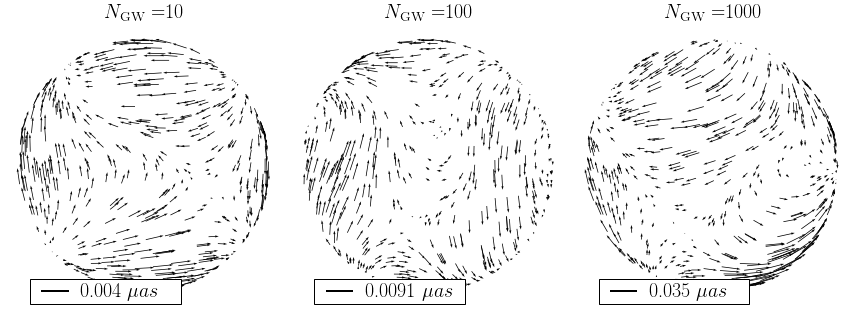

In [59]:
fig,axs = plt.subplots(1,3,figsize=(12,5))
starpos = -0.9
sblen = 0.2

for ind,i in enumerate([10,100,1000]):
    ax = axs[ind]
    ind_src = np.random.choice(np.arange(Ntot),size=i)
    
    hph = np.einsum('ijkl,ji->ikl',htotal[ind_src],pharr[:,ind_src])
#     dnls = up_cdn(hph,scr[:,ind_src],stc)
#     dnls = np.mean(np.linalg.norm(dnls,axis=0),axis=0)
#     ax.hist(dnls)[2]
#     print('N=',str(i))
#     print('mean=',np.mean(dnls))
#     print('std=',np.std(dnls))
    
    dnarr = np.sum(up_cdn(hph,scr[:,ind_src],stc),axis=-1)
    mag = np.mean(np.linalg.norm(dnarr,axis=1))/1.5
    
    ax.quiver(stc[0],stc[1],dnarr[0],dnarr[1],angles='xy',scale_units='xy',scale=mag)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(r'$N_{\rm GW}=$'+str(i))
    
    ax.add_patch(patches.Rectangle((starpos,starpos-0.2),1.2,0.2,facecolor='w',edgecolor='k'))
    ax.plot([starpos+0.1,starpos+0.1+sblen],[starpos-0.1,starpos-0.1],linewidth=2,color='k')

    ScaleBar = (sblen*u.rad*mag).to(1*u.uas).value
    ax.text(starpos+0.1+sblen+0.1,starpos-0.15,'{:.2g}'.format(ScaleBar)+r' $\mu as$',fontsize=20)
fig.tight_layout()
plt.savefig(folder+'dn.pdf',rasterized=True,dpi=450,bbox_inches='tight')

In [51]:
## Population synthesis
# zGW = 5
# Tobs = (5*365*u.d).to(1*u.s)
# dt = (15*u.min).to(1*u.s)
# fstart = 1/Tobs
# fend = 1/dt
# freq_popsynth = np.linspace(fstart.value,fend.value,int(Tobs/dt))
# df = np.diff(freq_popsynth)[0]

# Nsig = 100
# sigls = np.linspace(250,400,Nsig)
# logMbbh = np.log10(2)+logMBH(sigls) 
# np.log10(10**logMbbh*(1/4))
# logMcbbh = logMbbh+.6*np.log10(.25) 
# freq_isco = fISCO(logMcbbh)
# dsig = np.diff(sigls)[0]

# Nz = 200
# zls = np.linspace(0.01,zGW,Nz)
# dzls = np.diff(zls)[0]

# Schechter = np.empty([Nz,Nsig]) 
# for iz,zval in enumerate(zls):
#     Schechter[iz] = np.array([Sfun(zval,x) for x in sigls]).flatten()
# dNg = (Schechter/u.Mpc**3).to(1/u.m**3)/2.5
# N_sig_merg = np.sum(dNg/(1+zls.reshape([Nz,1]))**(1/3),axis=0)*dzls

# hc2arr_synth = np.zeros_like(freq_popsynth)
# for isig in range(Nsig):
#     x = min(freq_isco[isig]*u.s,fend*u.s)   
#     i1 = np.argmin(abs(freq_popsynth-x))  
#     Fr = freq_popsynth[:i1+1]  
#     hc2 = 4*(G*(10**logMcbbh[isig]*u.Msun).to(1*u.kg))**(5/3)/(3*pi**(1/3)*c**2*Fr**(4/3))*N_sig_merg[isig]
#     hc2arr_synth[:i1+1] += hc2.value*dsig

## Fig 3 v2: digitizer

In [ ]:
from numpy import genfromtxt
csvfolder = '/Users/WangYijun/Documents/学校文件/Astrometry/2022/0120/'

In [308]:
iptacsv = genfromtxt(csvfolder+'iptads.csv', delimiter=',')
ngcsv = genfromtxt(csvfolder+'ngds.csv', delimiter=',')
Aroman,Agaia = smbhlim

def gradient(x1_,x2_,y_,color_,AX_):
    nlayer = 30
    da = np.linspace(x1_,x2_,nlayer)
    layer_alp = 0.02
    for i in range(0,nlayer):
        AX_.fill_betweenx(y_,x1_,da[i],color=color_,alpha = layer_alp)
def setspine(AX_,LOW,HIGH):
    AX_.spines['bottom'].set_transform(AX_.transAxes)
    AX_.spines['bottom'].set_bounds(low=LOW, high=HIGH)
    AX_.spines['top'].set_transform(AX_.transAxes)
    AX_.spines['top'].set_bounds(low=LOW, high=HIGH)

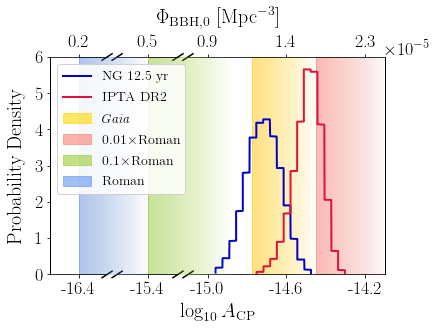

In [351]:
fig,ax = plt.subplots()
ax.plot(ngcsv[:,0],ngcsv[:,1],color='mediumblue',linewidth=2)
ax.plot(iptacsv[:,0],iptacsv[:,1],color='crimson',linewidth=2)
ax.set_ylim(0,6)
xticks = np.linspace(-15,-14.2,3)
ax.set_xticks(xticks)
ax.set_xticklabels(["%.1f" % x for x in xticks])
xmin1,xmax1 = -15.8,-14.1
ax.set_xlim(xmin1,xmax1)
_,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()

gradient(np.log10(Agaia),np.log10(Aroman*100),[ymin,ymax],'gold',ax)
gradient(np.log10(Aroman*100),xmax,[ymin,ymax],'salmon',ax)
ax.set_xlabel(r'$\log_{10}A_{\rm CP}$',va = 'top',labelpad=10)
ax.set_ylabel('Probability Density',va = 'bottom',labelpad=10)

# draw slash
d = .015  
xc = (-15.1-xmin1)/(xmax1-xmin1)
eps = 0.03
setspine(ax,xc,1)
xc2 = .2

## draw the Roman*0.1
ax3 = ax.twiny()
ax3.xaxis.tick_bottom()
value = np.log10(Aroman*10)
gradient(value,.97*value,[ymin,ymax],'yellowgreen',ax3)
xmin3 = -16
ctick1 = (xc2+xc-eps)/2
xmax3 = (value-xmin3)/ctick1+xmin3
ax3.set_xlim(xmin3,xmax3)
ax3.set_xticks([value])
ax3.set_xticklabels(["%.1f" % value])
setspine(ax3,xc2,xc-eps)

## draw Roman
ax4 = ax.twiny()
ax4.xaxis.tick_bottom()
value = np.log10(Aroman)
gradient(value,.92*value,[ymin,ymax],'cornflowerblue',ax4)
xmin3 = -17
ctick2 = (xc2-eps)/2
xmax3 = (value-xmin3)/ctick2+xmin3
ax4.set_xlim(xmin3,xmax3)
ax4.set_xticks([value])
ax4.set_xticklabels(["%.1f" % value])
setspine(ax4,0,xc2-eps)

kwargs = dict(transform=ax.transAxes, color='k',clip_on=False)
ax.plot((xc-d,xc+d), (-d, d), **kwargs)     
ax.plot((xc-d,xc+d), (1-d, 1+d), **kwargs)  
ax.plot((xc-eps-d,xc-eps+d), (-d, d), **kwargs)     
ax.plot((xc-eps-d,xc-eps+d), (1-d, 1+d), **kwargs)
ax.plot((xc2-d,xc2+d), (-d, d), **kwargs)     
ax.plot((xc2-d,xc2+d), (1-d, 1+d), **kwargs)  
ax.plot((xc2-eps-d,xc2-eps+d), (-d, d), **kwargs)     
ax.plot((xc2-eps-d,xc2-eps+d), (1-d, 1+d), **kwargs)

ax2 = ax.twiny()
ax2.set_xlim(xmin1,xmax1)
x = [ctick2*(xmax1-xmin1)+xmin1,ctick1*(xmax1-xmin1)+xmin1]+list(xticks)
ax2.set_xticks(x)
X = [value,value+1]+list(xticks)
V = [np.sqrt(10**x/(2.8e-15))*1.5 for x in X]
ax2.set_xticklabels(["%.1f" % z for z in V])
ax2.set_xlabel(r'$\Phi_{\rm BBH,0} ~[{\rm Mpc}^{-3}]$',va='bottom')
ax2.text(-14.1,6,r'$\times 10^{-5}$',va='bottom',fontsize=18)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

def drawlabel(COL,LAB):
    for i,col in enumerate(COL):
        ax4.fill_between([],[],[],color=col,label=LAB[i],alpha=0.6)
ax4.plot([],[],color='mediumblue',label='NG 12.5 yr',linewidth=2)
ax4.plot([],[],color='crimson',label='IPTA DR2',linewidth=2)

drawlabel(['gold','salmon','yellowgreen','cornflowerblue'],
          [r'$\textit{Gaia}$',r'$0.01\times$'+'Roman',r'$0.1\times$'+'Roman','Roman'])

fs = 18
# ax.text(np.log10(Agaia)+0.05,5.8,r'$\textit{Gaia}$',fontsize=fs,rotation=90,va='top',ha='left')
# ax.text(np.log10(Aroman*100)+0.05,5.8,r'$0.01\times$'+'Roman',fontsize=fs,rotation=90,va='top',ha='left')
# ax3.text(np.log10(Aroman*10)+0.08,5.8,r'$0.1\times$'+'Roman',fontsize=fs,rotation=90,va='top',ha='left')
# ax4.text(np.log10(Aroman)+0.2,5.8,'Roman',fontsize=fs,rotation=90,va='top',ha='left')
ax4.legend(fontsize=14,loc='upper left',bbox_to_anchor=(0.0,1),framealpha=0.87)

# plt.savefig(folder+'occfrac_v3.pdf',rasterized=True,dpi=450,bbox_inches='tight')

## Fig 3: implied local population

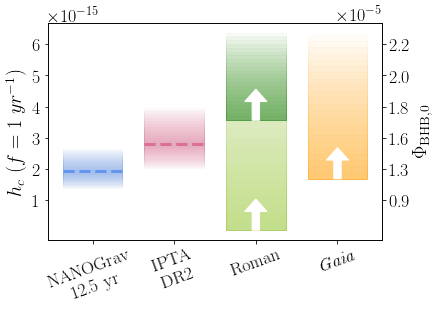

In [274]:
def gradient(xs_,yc_,y1_,y2_,color_):
    nlayer = 24
    layer_alp = 0.03
    for i in range(1,nlayer):
        ax.fill_between(xs_,yc_-(yc_-y1_)*i/nlayer,yc_+(y2_-yc_)*i/nlayer,color=color_,alpha=layer_alp)
#     ax.fill_between([],[],[],color=color_,label=label_,alpha=0.6)
    
fig,ax = plt.subplots()
xls = np.linspace(0,11,6)
ax.set_xticks(ticks=xls)
ax.set_xticklabels(labels=['','NANOGrav \n 12.5 yr','IPTA \n DR2','Roman',r'\textit{Gaia}',''],
                   rotation=20)
width = np.diff(xls)[0]-0.6
# nanograv
A = 1.92e-15
ap,am = 1.37e-15,2.67e-15
center = xls[1]
col = 'cornflowerblue'
gradient([center-width/2,center+width/2],A,am,ap,col)
hlinew = 3
ax.hlines(A,center-width/2,center+width/2,color=col,linewidth=hlinew,linestyle='dashed')

# IPTA
A = 2.8e-15
ap,am = 4e-15,2e-15
center = xls[2]
col = 'palevioletred'
gradient([center-width/2,center+width/2],A,am,ap,col)
ax.hlines(A,center-width/2,center+width/2,color=col,linewidth=hlinew,linestyle='dashed')

ymax = 6.5e-15
arrowl = 1e-15
hwidth = 0.6
hlength = 4e-16
stemw = 0.2

center = xls[3]
col = 'yellowgreen'
A = smbhlim[0]
gradient([center-width/2,center+width/2],A,A,ymax,col)
ax.arrow(center,A,0,arrowl, width=stemw, color="w", 
             head_width=hwidth, head_length=hlength,length_includes_head=True)

A = smbhlim[0]*100
col = 'forestgreen'
gradient([center-width/2,center+width/2],A,A,ymax,col)
ax.arrow(center,A,0,arrowl, width=stemw, color="w", 
             head_width=hwidth, head_length=hlength,length_includes_head=True)

center = xls[4]
col = 'orange'
A = smbhlim[1]
gradient([center-width/2,center+width/2],A,A,ymax,col)
ax.arrow(center,A,0,arrowl, width=stemw, color="w", 
             head_width=hwidth, head_length=hlength,length_includes_head=True)

ax.set_ylabel(r'$h_c~(f= 1~yr^{-1})$')
yticks = np.linspace(1e-15,6e-15,6)
ax.set_yticks(yticks)
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(yticks)
tlbs = np.sqrt(yticks/(2.8e-15))*1.5
ax2.set_yticklabels(['{:.1f}'.format(x) for x in tlbs])
ax2.set_ylabel(r'$\Phi_{\rm BHB,0}$')
ax2.text(center,6.7e-15,r'$\times 10^{-5}$',va='bottom',fontsize=18)
plt.savefig(folder+'occfrac.pdf',rasterized=True,dpi=450,bbox_inches='tight')

## Fig 2: source agnostic hc(f) sensitivity (don't use)

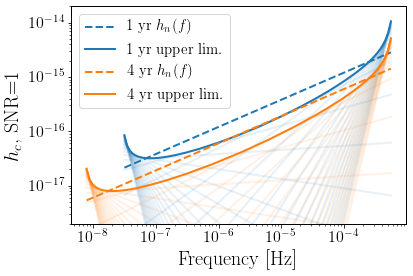

In [328]:
Ns = 1e8
cls = ['tab:blue','tab:orange']
dtobs = (15*u.min).to(1*u.s).value
Nf = 100
sig_ss = (1.1*u.mas).to(1*u.rad)
freq0 = 1e-6

fig,ax = plt.subplots(figsize=(6,4))
for it,t in enumerate([1,4]):
    Tobs = (t*u.yr).to(1*u.s).value
    Ntgrid = int(Tobs/dtobs/2)
    tgrid = np.linspace(0,Tobs,Ntgrid) 
    dt = np.diff(tgrid)[0]
    
    freqs = np.fft.fftfreq(Ntgrid,d=dt)
    dfreq = np.diff(freqs)[0]
    fmax = Ntgrid*dfreq
    dlogf = (np.log10(fmax)-np.log10(dfreq))/Nf
    freq = np.geomspace(dfreq,fmax,Nf)
    
    hc = np.sqrt(2*freq/u.s/Tobs/Ns)*sig_ss*dtobs
    ax.loglog(freq,hc,linewidth=2,color=cls[it],label=str(t)+' yr'+r' $h_n(f)$',linestyle='dashed')

    alpha_arr = np.linspace(-5,5,200)
    alpha_arr = np.concatenate([-np.flip(alpha_arr),alpha_arr])
    hcarr = np.empty([len(alpha_arr),len(freq)])

    for i,alpha in enumerate(alpha_arr):
        hcinj = (freq/freq0)**alpha
        A2 = 1/(dlogf*np.sum(((hcinj/hc)**2)))
        hcarr[i] = np.sqrt(A2)*hcinj
        if np.mod(i,5)==1:
            plt.loglog(freq,np.sqrt(A2)*hcinj,color=cls[it],alpha=0.05)
    ax.loglog(freq,np.amax(hcarr,axis=0),linewidth=2,label=str(t)+' yr'+r' upper lim.',color=cls[it])

ax.set_ylim(2e-18,2e-14)
ax.legend(loc='upper left',fontsize=15)
ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel(r'$h_c$, SNR=1')
# plt.savefig(folder+'src_agnostic.pdf',rasterized=True,dpi=450,bbox_inches='tight')

## BBH number density prediction
to be compared with Fig 5 in Izquierdo et al. 

In [17]:
Nsig = 100
sigls = np.linspace(100,400,Nsig)
logMbbh = np.log10(2)+logMBH(sigls) 
logMcbbh = logMbbh+.6*np.log10(.25) 
Schechter = np.array([Sfun(0,x) for x in sigls])
dlogsigdlogMc = (np.diff(np.log10(sigls))/np.diff(logMcbbh))[0]

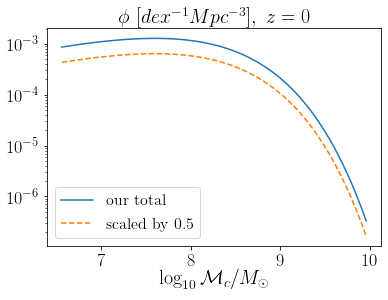

In [52]:
h = 0.7
plt.semilogy(logMcbbh,Schechter/h**3*sigls*dlogsigdlogMc,label='our total')
plt.semilogy(logMcbbh,Schechter/h**3*sigls*dlogsigdlogMc*0.5,linestyle='dashed',label='scaled by 0.5')
plt.xlabel(r'$\log_{10} \mathcal{M}_c/M_\odot$')
plt.title(r'$\phi~[dex^{-1}Mpc^{-3}],~z=0$')
plt.legend(fontsize=16)

## Fig 4: Occupation fraction constraint

In [429]:
## frequency range
datals = [[1e8,1.1*u.mas,(15*u.min).to(1*u.s).value],
          [1e9,0.7*u.mas,(5/70*u.yr).to(1*u.s).value]]
tls = np.linspace(0.3,5,50)
occfrac = np.empty([2,len(tls)])
for idet,data in enumerate(datals):
    Ns,sig_ss,dt = data
    sig_ss = sig_ss.to(1*u.rad)
    occls = np.empty(len(tls))
    for it,t in enumerate(tls):
        Tobs = (t*u.yr).to(1*u.s).value
        N = int(Tobs/dt)
        fstart = 1/Tobs
        fend = 1/dt
        freq = np.linspace(fstart,fend,N)
        df = np.diff(freq)[0]

        hc2arr = np.zeros_like(freq)
        for isig in range(Nsig):
            x = min(freq_isco[isig]*u.s,fend)   
            i1 = np.argmin(abs(freq-x))  
            Fr = freq[:i1+1]  
            hc2 = 4*(G*(10**logMcbbh[isig]*u.Msun).to(1*u.kg))**(5/3)/(3*pi**(1/3)*c**2*Fr**(4/3))*N_sig_merg[isig]
            hc2arr[:i1+1] += hc2.value*dsig
        hc_uns = np.sqrt(hc2arr)
        
        hc = np.sqrt(2*freq/u.s/Tobs/Ns)*sig_ss*dt
        occls[it] = 1/(df*np.sum(((hc_uns/hc)**2/freq))).value
    occfrac[idet] = [min(x,1) for x in occls]

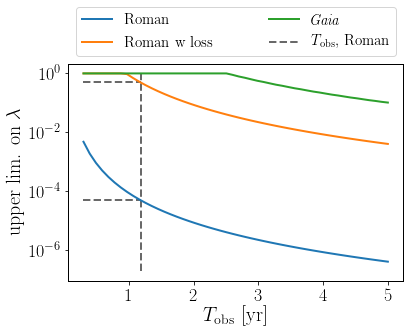

In [453]:
roman = (6*72*u.d).to(1*u.yr).value
fig,ax = plt.subplots(figsize=(6,4))
ax.semilogy(tls,occfrac[0],label=r'Roman',linewidth=2)
ax.semilogy(tls,[min(x,1) for x in occfrac[0]*100**2],label=r'Roman w loss',linewidth=2)
ax.semilogy(tls,occfrac[1],label=r'$\textit{Gaia}$',linewidth =2)

func = interp1d(tls,occfrac[0])
ymin,ymax = ax.get_ylim()
ax.vlines(roman,ymin,1,color='dimgrey',linestyle='dashed')
ax.hlines(func(roman),min(tls),roman,color='dimgrey',linestyle='dashed')
ax.hlines(func(roman)*100**2,min(tls),roman,color='dimgrey',linestyle='dashed')
ax.plot([],[],linestyle='dashed',color='dimgrey',label=r'$T_{\rm obs}$, Roman')
ax.set_xlabel(r'$T_{\rm obs}$ [yr]')
ax.set_ylabel(r'upper lim. on $\lambda$')
ax.legend(loc='lower left',mode='expand',bbox_to_anchor=(0,1.0,1,0.2),ncol=2
          ,fontsize=15)
# plt.savefig(folder+'occfrac.pdf',rasterized=True,dpi=450,bbox_inches='tight')

In [373]:
g = 6.67e-11*u.m**3/u.kg/u.s**2
c = 3e8*u.m/u.s
(1*u.Msun).to(1*u.kg)*g/c**3

<Quantity 4.91227075e-06 s>